In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

In [2]:
names = open("names.txt", "r").read().splitlines()
print(f"We have {len(names)} names and the first 8 are: {names[:8]}")

We have 32033 names and the first 8 are: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
vocabulary = sorted(list(set("".join(names))))
stoi = {s: i+1 for i, s in enumerate(vocabulary)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

In [4]:
contextLength = 3
def buildDataset(words, contextLength):
    X, Y = [], [] # has to be ints not chars
    for word in words:
        context = [0] * contextLength
        for char in word + ".":
            y_context = stoi[char]
            X.append(context)
            Y.append(y_context)
            print(f"{''.join(itos[i] for i in context)} ---> {itos[y_context]}")
            context = context[1:] + [y_context]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"Returning X of shape {X.shape} and Y of shapre {Y.shape}")
    return X, Y

import random
random.shuffle(names)
split = int(0.8*len(names))
Xtr, Ytr = buildDataset(names[:split], contextLength)
Xval, Yval = buildDataset(names[split:], contextLength)

... ---> a
..a ---> b
.ab ---> y
aby ---> g
byg ---> a
yga ---> y
gay ---> l
ayl ---> e
yle ---> .
... ---> t
..t ---> y
.ty ---> r
tyr ---> o
yro ---> n
ron ---> e
one ---> .
... ---> j
..j ---> a
.ja ---> y
jay ---> v
ayv ---> i
yvi ---> e
vie ---> r
ier ---> .
... ---> r
..r ---> e
.re ---> i
rei ---> g
eig ---> h
igh ---> n
ghn ---> a
hna ---> .
... ---> n
..n ---> a
.na ---> l
nal ---> e
ale ---> i
lei ---> a
eia ---> .
... ---> t
..t ---> a
.ta ---> v
tav ---> i
avi ---> n
vin ---> .
... ---> s
..s ---> h
.sh ---> a
sha ---> t
hat ---> h
ath ---> a
tha ---> .
... ---> k
..k ---> a
.ka ---> m
kam ---> a
ama ---> a
maa ---> l
aal ---> .
... ---> s
..s ---> h
.sh ---> y
shy ---> e
hye ---> n
yen ---> n
enn ---> e
nne ---> .
... ---> b
..b ---> r
.br ---> o
bro ---> d
rod ---> i
odi ---> .
... ---> w
..w ---> y
.wy ---> l
wyl ---> a
yla ---> .
... ---> t
..t ---> i
.ti ---> n
tin ---> l
inl ---> e
nle ---> e
lee ---> .
... ---> k
..k ---> e
.ke ---> d
ked ---> r
edr ---> i
dri ---> c

In [69]:
vocabEmbeddingSize = 10
hiddenNeurons = 200
vocabSize = len(stoi.items())

C = torch.randn((vocabSize, vocabEmbeddingSize))
W1 = torch.randn((vocabEmbeddingSize*contextLength, hiddenNeurons))     * (5/3) / (vocabEmbeddingSize*contextLength)**0.5 # gain/sqrt(fan_in)
#b1 = torch.randn(hiddenNeurons)                                         * 0.01
W2 = torch.randn(hiddenNeurons, vocabSize)                              * 0.01
b2 = torch.randn(vocabSize)                                             * 0.01


bn_gain = torch.ones((1, hiddenNeurons))
bn_bias = torch.zeros(1, hiddenNeurons)
bn_mean_running = torch.zeros(1, hiddenNeurons)
bn_std_running = torch.ones((1, hiddenNeurons))

In [70]:
parameters = [C, W1, W2, b2, bn_gain, bn_bias]
print(f"We have {sum(p.nelement() for p in parameters)} parameters in total")
for p in parameters:
  p.requires_grad = True

We have 12097 parameters in total


In [71]:
for p in parameters:
  p.requires_grad = True

In [72]:
loss_i = []
step_i = []
batchSize = 32
for i in range(200000):
    batchIndexes = torch.randint(0, Xtr.shape[0], (batchSize,))
    
    # forward pass
    embeddings = C[Xtr[batchIndexes]]
    tanhpreact = embeddings.view(-1, vocabEmbeddingSize*contextLength) @ W1 # + b1
    bn_mean_i = tanhpreact.mean(0, keepdims=True)
    bn_std_i = tanhpreact.std(0, keepdims=True)
    tanhpreact = bn_gain * (tanhpreact - bn_mean_i) / bn_std_i + bn_bias

    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i
        
    layer1tanh = torch.tanh(tanhpreact)
    logits = layer1tanh @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[batchIndexes])
    if i % 1000 == 0:
        print(f"Loss for batch {i}: {loss.item()}")

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update params
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    step_i.append(i)
    loss_i.append(loss.item())

Loss for batch 0: 3.31900954246521
Loss for batch 1000: 2.320943832397461
Loss for batch 2000: 2.7928054332733154
Loss for batch 3000: 1.9752047061920166
Loss for batch 4000: 2.3521056175231934
Loss for batch 5000: 2.1387557983398438
Loss for batch 6000: 2.3988566398620605
Loss for batch 7000: 2.690479278564453
Loss for batch 8000: 2.123737335205078
Loss for batch 9000: 1.876479983329773
Loss for batch 10000: 2.3327839374542236
Loss for batch 11000: 2.3695850372314453
Loss for batch 12000: 2.0404651165008545
Loss for batch 13000: 2.2678651809692383
Loss for batch 14000: 2.0752267837524414
Loss for batch 15000: 2.7452232837677
Loss for batch 16000: 1.9387620687484741
Loss for batch 17000: 2.677070379257202
Loss for batch 18000: 2.170546770095825
Loss for batch 19000: 2.209012508392334
Loss for batch 20000: 2.0366227626800537
Loss for batch 21000: 2.328245162963867
Loss for batch 22000: 1.9994361400604248
Loss for batch 23000: 2.223722219467163
Loss for batch 24000: 2.629098892211914
Los

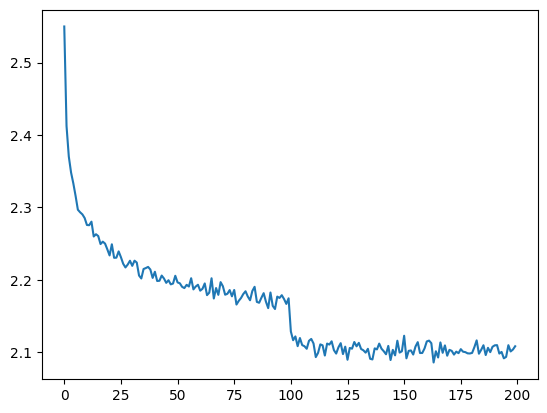

In [73]:
plt.plot(torch.tensor(loss_i).view(-1, 1000).mean(1))

In [74]:
@torch.no_grad()
def split_loss(split):
    X, Y = {'train': (Xtr, Ytr), 'val': (Xval, Yval)}[split]
    embeddings = C[X]
    tanhpreact = embeddings.view(-1, vocabEmbeddingSize*contextLength) @ W1# + b1
    tanhpreact = bn_gain * (tanhpreact - bn_mean_running) / bn_std_running + bn_bias
    layer1tanh = torch.tanh(tanhpreact)
    logits = layer1tanh @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("val")


train loss: 2.069032907485962
val loss: 2.1047210693359375


In [75]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * contextLength # initialize with all ...
    while True:
      embeddings = C[torch.tensor([context])] # (1,block_size,d)
      tanhpreact = embeddings.view(-1, vocabEmbeddingSize*contextLength) @ W1# + b1
      tanhpreact = bn_gain * (tanhpreact - bn_mean_running) / bn_std_running + bn_bias
      layer1tanh = torch.tanh(tanhpreact)
      logits = layer1tanh @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

skylynn.
aubreyel.
jeire.
gol.
jahetian.
mam.
nishille.
rage.
kakrisha.
jassarayniah.
abdulfianovan.
domon.
zariandra.
fruez.
lade.
jolan.
aud.
vamina.
leen.
dextya.
